# Spell Checker and Grammaticality Test using Language Modelling

## Imports and Initializations

Firstly, we will import packages like `os`, `re`, `matplotlib.pyplot`, etc and initialize the `PrettyPrinter` for printing data in an organized manner.

In [1]:
import os, re, pprint
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

pp = pprint.PrettyPrinter(indent=2)

CORPUS_PATH = "/Users/sounak/Documents/clg/nlp/nlp-projects/data/Gutenberg/txt"

## Tokenizer

Now we write our tokenizer class, which will have methods to handle sentence as well as word tokenizing.

In [2]:
class Tokenizer:
    def postproc_word(self, words):
        new_words = []
        for word in words:
            new_words.extend(re.findall(r"[\w']+|[\".,!?;]", word))
        return new_words
    
    def into_words(self, text, punctuation=False):
        if not punctuation:
            words = [_.lower() for _ in re.split(r"[^a-zA-ZÀ-ÿ0-9']+", text)]
            return list(filter(('').__ne__, words))
        else:
            words = [_ for _ in re.split(r"[^a-zA-ZÀ-ÿ0-9,.?!/-:;\"']+", text)]
            return self.postproc_word(words)

    def into_sentences(self, text):
        text = " " + text + "  "
        text = text.replace("\n"," ")
        text = re.sub(self.prefixes,"\\1<prd>",text)
        text = re.sub(self.websites,"<prd>\\1",text)
        if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
        text = re.sub("\s" + self.caps + "[.] "," \\1<prd> ",text)
        text = re.sub(self.acronyms+" "+self.starters,"\\1<stop> \\2",text)
        text = re.sub(self.caps + "[.]" + self.caps + "[.]" + self.caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
        text = re.sub(self.caps + "[.]" + self.caps + "[.]","\\1<prd>\\2<prd>",text)
        text = re.sub(" "+self.suffixes+"[.] "+self.starters," \\1<stop> \\2",text)
        text = re.sub(" "+self.suffixes+"[.]"," \\1<prd>",text)
        text = re.sub(" " + self.caps + "[.]"," \\1<prd>",text)
        if "”" in text: text = text.replace(".”","”.")
        if "\"" in text: text = text.replace(".\"","\".")
        if "!" in text: text = text.replace("!\"","\"!")
        if "?" in text: text = text.replace("?\"","\"?")
        text = text.replace(".",".<stop>")
        text = text.replace("?","?<stop>")
        text = text.replace("!","!<stop>")
        text = text.replace("<prd>",".")
        sentences = text.split("<stop>")
        sentences = sentences[:-1]
        sentences = [s.strip() for s in sentences]
        return sentences
            
    def get_words_counter(self):
        return self.words
    
    def get_sentences(self):
        return self.sentences
    
    def __init__(self, texts):
        self.caps = "([A-Z])"
        self.prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
        self.suffixes = "(Inc|Ltd|Jr|Sr|Co)"
        self.starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
        self.acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
        self.websites = "[.](com|net|org|io|gov)"
        
        self.words = Counter([])
        self.sentences = []
        for text in texts:
            self.words.update(self.into_words(text))
            for sentence in self.into_sentences(text):
                self.sentences.append(self.into_words(sentence))

## Language Modelling

After tokenizing we will need to write a class which will handle the language modelling using `n-grams`. This class will also have methods which will give a score to a particular sequence, thus helping us in our final tasks of spell checker and grammaticality test.

In [3]:
class LM:
    def N(self, c, l):
        try:
            return self.N_values[(c, l)]
        except KeyError:
            self.N_values[(c, l)] = len([v for (k, v) in self.get_model(l).items() if v == c])
            return self.N_values[(c, l)]
    
    def get_model(self, n):
        try:
            return self.models[n]
        except KeyError:
            self.models[n] = self.language_model(self.groups, n)
            return self.models[n]

    def get_count(self, token):
        model = self.get_model(len(token))
        return model[token] if token in model.keys() else 0 

    def get_count_gt(self, token):
        try:
            return self.gt_counts[token]
        except KeyError:
            l = len(token)
            model = self.get_model(l)
            if token not in model.keys():
                self.gt_counts[token] = self.N(1, l) / sum(model.values())
                return self.gt_counts[token]
            else:
                c = model[token]
                max_freq = model.most_common(1)[0][1]
                c_ = c + 1
                while c_ < max_freq:
                    if self.N(c_, l) != 0:
                        if self.N(c_, l) == self.N(c, l):
                            self.gt_counts[token] = c
                            return self.gt_counts[token]
                        self.gt_counts[token] = c_ * self.N(c_, l) / self.N(c, l)
                        return self.gt_counts[token]
                    c_ += 1
                self.gt_counts[token] = c
                return self.gt_counts[token]
                
    def get_prob_gt(self, token):
        try:
            return self.gt_probs[token]
        except KeyError:
            l = len(token)
            self.gt_probs[token] = (self.get_count_gt(token) + 1) / (self.get_count_gt(token[:-1]) + len(self.get_model(l-1).keys()))
            return self.gt_probs[token]

    def get_prob_laplace(self, token, factor=1):
        try:
            return self.laplace_probs[(token, factor)]
        except KeyError:
            l = len(token)
            token = tuple(token)
            self.laplace_probs[(token, factor)] = (self.get_count(token) + factor) / (self.get_count(token[:-1]) + len(self.get_model(l-1).keys()))
            return self.laplace_probs[(token, factor)]
        
    def get_ngrams(self, group, n):
        ngrams = []
        group = (' ',) + tuple(group) + (' ',)
        for i in range(len(group)-n+1):
            ngrams.append(group[i:i+n])
        return ngrams

    def predict_next(self, sequence, n):
        prob = {}
        sequence = tuple(sequence)
        length = len(sequence)
        alphabet = self.models[1].keys()
        for letter in alphabet:
            gram = sequence + letter
            prob[gram] = self.get_score(gram, n)
        return sorted(prob.items(), key=lambda item: item[1], reverse=True)

    def get_score(self, group, n, log=True):
        grams = self.get_ngrams(group, n)
        probs = []
        for gram in grams:
            probs.append(self.get_prob_gt(gram))
        if log:
            return np.log(probs).sum()
        return np.array(probs).prod()
    
    def S(self, token, factor=0.4):
        if len(token) == 1:
            return self.get_count(token) / sum(self.get_model(1).values())
        if self.get_count(token) > 0:
            return self.get_count(token) / self.get_count(token[:-1])
        return factor * self.S(token[1:])

    def get_score_backoff(self, group, n, factor=0.4, log=True):
        grams = self.get_ngrams(group, n)
        probs = []
        for gram in grams:
            probs.append(self.S(gram))
        if log:
            return np.log(probs).sum()
        return np.array(probs).prod()

    def language_model(self, groups, n):
        ngrams = Counter([])
        for group in groups:
            ngrams.update(self.get_ngrams(group, n))
        return ngrams

    def __init__(self, groups):
        self.groups = groups
        self.N_values = {}
        self.gt_counts = {}
        self.gt_probs = {}
        self.laplace_probs = {}
        self.models = {}
        for n in range(1, 5):
            self.models[n] = self.language_model(self.groups, n)

## Tokenizing the corpus

Now that we have written the code for both tokenizing and language modelling, we will tokenize the [Gutenberg Corpus](https://drive.google.com/file/d/0B2Mzhc7popBga2RkcWZNcjlRTGM/edit) into sentences and words.

In [4]:
files = os.listdir(CORPUS_PATH)
files.remove('Henry David Thoreau___A Week on the Concord and Merrimack Rivers.txt')
files = files[:20]
texts = []

for file in files:
    file = os.path.join(CORPUS_PATH, file)
    f = open(file, 'r')
    texts.append(f.read())
    f.close()
    
t = Tokenizer(texts)
words = t.get_words_counter()
sentences = t.get_sentences()

## Zipf's Law

Now, we are going to verify the Zipf's Law by plotting the frequency of the first 1000 words.

[ ('the', 46909),
  ('and', 27225),
  ('of', 25839),
  ('to', 25382),
  ('a', 18189),
  ('in', 13176),
  ('i', 13159),
  ('that', 11945),
  ('it', 11355),
  ('was', 10275)]


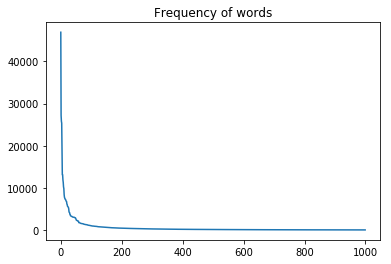

In [5]:
pp.pprint(words.most_common(10))

y = [b for a, b in words.most_common(1000)]
x = range(len(y))

plt.plot(x, y)
plt.title('Frequency of words')
plt.show()

## Language Models for Words

Using `LM` and the built-in methods we will build the language models for the words that we just extracted from the corpus.

[ (('e', 'd', ' '), 2757),
  (('i', 'n', 'g'), 2404),
  (('n', 'g', ' '), 2081),
  (('e', 's', ' '), 1441),
  (('l', 'y', ' '), 1128),
  ((' ', 'c', 'o'), 1039),
  (('i', 'o', 'n'), 967),
  (('e', 'r', ' '), 901),
  (('e', 'n', 't'), 860),
  ((' ', 'r', 'e'), 835)]
[ (('a', 'p', 'm'), 1),
  (('s', 'r', 's'), 1),
  (('a', 'u', 'a'), 1),
  (('o', 'b', 'n'), 1),
  ((' ', 'i', 'a'), 1),
  (('d', 'j', 'e'), 1),
  (('m', 'm', 's'), 1),
  (('d', 'é', 'e'), 1),
  (('n', 'd', 'é'), 1),
  (("'", 'e', 'd'), 1)]


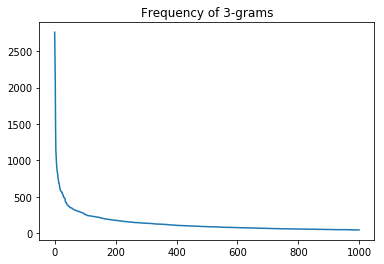

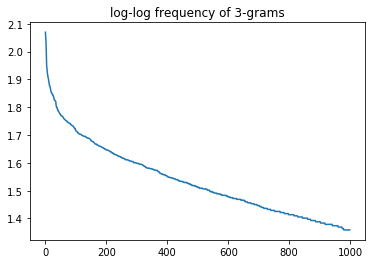

In [6]:
words_lm = LM(words.keys())

pp.pprint(words_lm.get_model(3).most_common(10))
pp.pprint(words_lm.get_model(3).most_common()[:-11:-1])

y1 = np.array([b for a, b in words_lm.get_model(3).most_common(1000)])
y2 = np.log(np.log(y1))
x = np.arange(len(y1))
plt.plot(x, y1)
plt.title('Frequency of 3-grams')
plt.show()
plt.plot(x, y2)
plt.title('log-log frequency of 3-grams')
plt.show()

### Completing (n-1)-grams to predict the next gram

[ (('k', 'i', 'l', 'e'), -10.492073509794164),
  (('k', 'i', 'l', 'y'), -10.66846541710378),
  (('k', 'i', 'l', 'd'), -11.716180656386525),
  (('k', 'i', 'l', 'l'), -12.051332340279295),
  (('k', 'i', 'l', 's'), -13.246047870730585),
  (('k', 'i', 'l', 't'), -13.548614063399304),
  (('k', 'i', 'l', 'i'), -14.525418476274815),
  (('k', 'i', 'l', 'a'), -14.654780974171725),
  (('k', 'i', 'l', 'f'), -15.117023336319287),
  (('k', 'i', 'l', 'o'), -15.432543727784408),
  (('k', 'i', 'l', 'k'), -16.08508279885199),
  (('k', 'i', 'l', 'm'), -16.722896271387853),
  (('k', 'i', 'l', ' '), -17.427708258940406),
  (('k', 'i', 'l', 'n'), -17.827686182852435),
  (('k', 'i', 'l', 'u'), -17.898883170785176),
  (('k', 'i', 'l', "'"), -18.188137275578303),
  (('k', 'i', 'l', 'g'), -18.53839158722276),
  (('k', 'i', 'l', 'p'), -18.556748048384556),
  (('k', 'i', 'l', 'b'), -18.80422740587226),
  (('k', 'i', 'l', 'h'), -18.842134967011248),
  (('k', 'i', 'l', 'z'), -19.026876576844575),
  (('k', 'i', 'l'

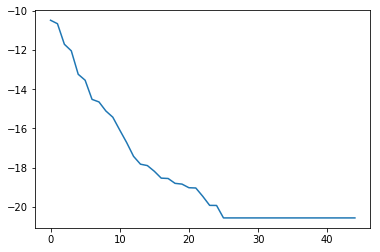

In [7]:
predictions = words_lm.predict_next('kil', 3)
pp.pprint(predictions)

y = [v for k, v in predictions]
x = range(len(y))

plt.plot(x, y)
plt.show()

## Language Models for Sentences

Using `LM` and the built-in methods we will build the language models for the sentences that we just extracted from the corpus.

[ ((' ', 'it', 'was'), 678),
  ((' ', 'it', 'is'), 579),
  (('one', 'of', 'the'), 371),
  ((' ', 'i', 'have'), 350),
  ((' ', 'i', 'am'), 318),
  ((' ', 'he', 'was'), 265),
  (('as', 'soon', 'as'), 245),
  ((' ', 'there', 'is'), 212),
  (('it', 'would', 'be'), 204),
  ((' ', 'he', 'had'), 200)]
[ (('chapman', 'hall', ' '), 1),
  (('messrs', 'chapman', 'hall'), 1),
  (('of', 'messrs', 'chapman'), 1),
  (('permission', 'of', 'messrs'), 1),
  (('by', 'permission', 'of'), 1),
  (("'", 'by', 'permission'), 1),
  (('review', "'", 'by'), 1),
  (("'fortnightly", 'review', "'"), 1),
  (('the', "'fortnightly", 'review'), 1),
  (('from', 'the', "'fortnightly"), 1)]


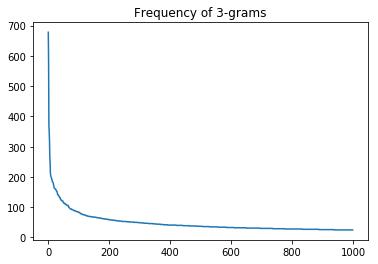

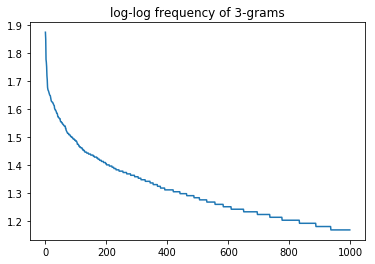

In [8]:
sents_lm = LM(sentences)

pp.pprint(sents_lm.get_model(3).most_common(10))
pp.pprint(sents_lm.get_model(3).most_common()[:-11:-1])

y1 = np.array([b for a, b in sents_lm.get_model(3).most_common(1000)])
y2 = np.log(np.log(y1))
x = np.arange(len(y1))
plt.plot(x, y1)
plt.title('Frequency of 3-grams')
plt.show()
plt.plot(x, y2)
plt.title('log-log frequency of 3-grams')
plt.show()

### Completing (n-1)-grams to predict the next gram

In [ ]:
predictions = sents_lm.predict_next(['i', 'am', 'going'], 3)
pp.pprint(predictions)

y = [v for k, v in predictions]
x = range(len(y))

plt.plot(x, y)
plt.show()

## The function N: frequency of frequencies

In Good Turing Smooting we use the probability _(essentially, the frequency)_ of the grams that occur once in the corpus to estimate the probability of new unseen words.

So, we define a function `N: c -> f`, which gives the frequency of frequency `c` in the corpus.

### Plotting the N function

We will be plotting the function N in the domain `(1, max)` where `max` is the frequency of the gram with the maximum frequency.

In [ ]:
max_freq = words_lm.get_model(3).most_common(1)[0][1]
x = range(1, max_freq + 1)
x1 = range(1, 101)
x2 = range(101, 151)
x3 = range(151, 201)

y = [words_lm.N(_, 3) for _ in x]
y1 = [words_lm.N(_, 3) for _ in x1]
y2 = [words_lm.N(_, 3) for _ in x2]
y3 = [words_lm.N(_, 3) for _ in x3]

plt.plot(y)
plt.show()
plt.plot(x1, y1)
plt.show()
plt.plot(x2, y2)
plt.show()
plt.plot(x3, y3)
plt.show()

### Anomalies in the plot

As we can see in the plots, the function N looks like an exponential function. As we increase the value of `c`, we get abnormal results because the frequency of some high frequencies can be 0. And as a result of this we can get wrong values of Good Turing smoothed probabilites of grams.

As we can see in the following example where the gram `(i, am)` has a count which is __not zero__, but the function `N` returns 0, and thus giving a wrong count of the gram. 

In [ ]:
gram = ('i', 'am')
c = sents_lm.get_count(gram)
pp.pprint(c)
pp.pprint(sents_lm.N((c + 1), len(gram)))

### How do we solve this?

`(c+1)N(c+1)/N(c)` is the term that approximates the count. `N(c)` will never be zero if the token is present in the corpus, but `N(c+1)` can. This is because there might be integers which are not the frequency of any particular ngram in the corpus.

What we can do instead is use the term `(c+k)N(c+k)/N(c)` where `c+k` is the next non-zero `c`.

Another problem that we will face is for cases where both the ngram and the n-1-gram (the one forming the ngram) are unseen. In this case the probability will be high and thus resulting in a significantly higher score, whereas the grams by themselves occur with a very less frequency. So, we are applying laplace smoothing while calculating the probability of the gram with the _Good-Turing_ estimated counts.

## Spell Checker

We are going upto two depths of editing _(generating a lot of possible corrections)_ and then evaluating the words which have been seen in the corpus on the basis of the score given by the `LM.get_score(group, n)`. There are a few tests that show that it is correcting the wrong spellings with good efficiency.

In [ ]:
alphabet = words_lm.get_model(1).keys()

def final_spell_score(word, n):
    score = words_lm.get_score(word, n)
    return score / len(word)

def known(words_):
    return set(w for w in words_ if w in words.keys())

def edits1(word):
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c[0] + R[1:]           for L, R in splits if R for c in alphabet]
    inserts    = [L + c[0] + R               for L, R in splits for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    return [e2 for e1 in edits1(word) for e2 in edits1(e1)]

def suggestions(word):
    return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
    
def correction(word, n):
    corrected = max(suggestions(word), key=(lambda word : final_spell_score(word, n)))
    return corrected, final_spell_score(corrected, n), final_spell_score(word, n)

test_words1 = ['chidken', 'unnecesary', 'writef', 'elephnt', 'mashroom']

for word in test_words1:
    pp.pprint(correction(word, 3))

## Grammaticality Test

We are scoring the sentences on an approximate scale which assigns _100_ to be the score given by the model to the most common ngram and _0_ to a random wrong sentence. This makes it easier for human evaluation. The tests show that the grammatical sentences are getting a significant higher score than the wrong ones.

In [ ]:
test_sents = [
    ['i', 'am', 'going', 'home'],
    ['i', 'am', 'home', 'going'],
    ['i', 'home', 'going', 'am'],
    ['it', 'is', 'the', 'most'],
    ['most', 'the', 'it', 'is'],
    ['the', 'most', 'it', 'is'],
    ['he', 'read', 'a', 'book'],
    ['he', 'a', 'book', 'read'],
    ['i', 'am', 'a', 'boy'],
    ['i', 'a', 'boy', 'am']
]

def compute_score_final(sentence, n):
    l = len(sentence)
    max_sent = sents_lm.get_model(l).most_common(1)[0][0]
    min_sent = ['brick' for i in range(l)]
    
    max_score = sents_lm.get_score(max_sent, n)
    min_score = sents_lm.get_score(min_sent, n)
    
    score = sents_lm.get_score(sentence, n) + np.abs(min_score)
    return score * (100 / (max_score + np.abs(min_score)))

for s in test_sents:
    pp.pprint((compute_score_final(s, 3)))